In [1]:
# MAKE A PIPELINE FOR PROCESSING THE COLOR IMAGES!
# FROM TIRAMISU
# IDEA: Add neck to the posture map?
# %matplotlib inline
# %matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import sys, os, pickle
import cv2
from colour import Color
import h5py
from tqdm import tqdm, tqdm_notebook


In [2]:
# Check CUDA

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch_device)

True
1
GeForce RTX 2080 Ti
cuda:0


# Make the hourglass net

In [3]:
# import the hourglass model and set up architecture
from architectures.hourglass import hg
global best_acc

model = hg(
    num_stacks=3,
    num_blocks=1,
    num_channels=1,
    num_classes=11,
    num_feats=128,
    inplanes=64,
    init_stride=2,
)
    
model = torch.nn.DataParallel(model).cuda()


# Load well-trained weights and apply to the hourglass

In [4]:
# A HELPER FUNCTION WHICH SAVES THE STATE OF THE NETWORK, maybe every 10 epochs or smth?
import os
import sys
import math
import string
import random
import shutil
import glob
epoch = 50

epoch = 89

# save_weights(model, 0, 1000)    
# def load_weights(model, epoch):
WEIGHTS_PATH = '192x320_weights/'
WEIGHTS_PATH = '/media/chrelli/SSD4TB/revision_profiling/{}_STACKS_NOPAF/'.format(3)

# # the the most recent from that epoch
# all_options = sorted( glob.glob(WEIGHTS_PATH + '/singlecore_weights_epoch_'+str(epoch)+'*' ) )
# print(all_options)
# weights_fpath = all_options[0]

# CHOSEN
# weights_fpath = WEIGHTS_PATH + 'singlecore_weights_epoch_135_loss_1565.910_2019-11-22_11-14-39.pth'
# weights_fpath = WEIGHTS_PATH + 'singlecore_weights_epoch_119_loss_97.685_2020-08-20_13-15-51.pth'

# for ir images:
# weights_fpath = WEIGHTS_PATH + 'singlecore_weights_epoch_89_loss_619.624_2020-08-21_22-16-15.pth'

# new ir resolution
# weights_fpath = WEIGHTS_PATH + 'singlecore_weights_epoch_89_loss_362.609_2020-08-28_21-23-09.pth'




def load_model(WEIGHTS_PATH,N_STACKS,EPOCH,verbose=False):
    # Load a model!
    # import the hourglass model and set up architecture
    from architectures.hourglass import hg
    global best_acc

    model = hg(
        num_stacks=N_STACKS,
        num_blocks=1,
        num_channels=1,
        num_classes=11,
        num_feats=128,
        inplanes=64,
        init_stride=2,
    )

    model = torch.nn.DataParallel(model).cuda()


    # A HELPER FUNCTION WHICH SAVES THE STATE OF THE NETWORK, maybe every 10 epochs or smth?
    import os
    import sys
    import math
    import string
    import random
    import shutil
    import glob

    # Find the path to the saved weights
    all_options = sorted( glob.glob(WEIGHTS_PATH + '/singlecore_weights_epoch_'+str(EPOCH)+'*' ) )
    if verbose:
        print(all_options)
    weights_fpath = all_options[0]
    if verbose:
        print("loading weights '{}'".format(weights_fpath))
    model.load_state_dict( torch.load(weights_fpath) )
    model.eval()
    if verbose:
        print('loaded!')
    return model


WEIGHTS_PATH = '/media/chrelli/SSD4TB/revision_profiling/{}_STACKS_NOPAF/'.format(3)
N_STACKS = 3
EPOCH = 89

model = load_model(WEIGHTS_PATH,N_STACKS,EPOCH, verbose = True)

print('loaded!')



['/media/chrelli/SSD4TB/revision_profiling/3_STACKS_NOPAF/singlecore_weights_epoch_89_loss_16.715_2020-10-30_20-11-07.pth']
loading weights '/media/chrelli/SSD4TB/revision_profiling/3_STACKS_NOPAF/singlecore_weights_epoch_89_loss_16.715_2020-10-30_20-11-07.pth'
loaded!
loaded!


# Wrap images in pytorch dataset and make helper functions

In [5]:
# load a stacvk of some sorted frames!

import numpy as np
import cv2
import h5py
import matplotlib.pyplot as plt
# from deepposekit import VideoReader, KMeansSampler
import sys
# sys.path.append('/home/chrelli/git/3d_sandbox/mouseposev0p1/chrelli_annotator/')
# sys.path.append('/home/chrelli/git/3d_sandbox/mousepose_0p1/deepposekit-annotator/')

# from dpk_annotator import VideoReader, KMeansSampler
import tqdm
import glob
import itertools

from os.path import expanduser
home = expanduser("~")


In [6]:
# load the geometry

# mice with speckles
top_folder_0 = '/media/chrelli/Data0/recording_20200821-131033'
top_folder_1 = '/media/chrelli/Data1/recording_20200821-131033'

# training data with different exposure
top_folder_0 = '/media/chrelli/Data0/recording_20200828-113642/'
top_folder_1 = '/media/chrelli/Data1/recording_20200828-113642/'

# validation dataset with LASER ON 90 fps
top_folder_0 = '/media/chrelli/Data0/recording_20200828-114251/'
top_folder_1 = '/media/chrelli/Data1/recording_20200828-114251/'

scene_folders = [top_folder_0,top_folder_0,top_folder_1,top_folder_1]
import pickle
# geometry = pickle.load( open( scene_folders[0]+'/geometry.pkl', "rb" ) ) 
# timing = pickle.load( open( scene_folders[0]+'/timing.pkl', "rb" ) )
# print(geometry.keys())
# print(timing.keys())

In [7]:
# also make a list of all the frames to process
# make a list of the cameras!
png_files = [glob.glob(scene_folders[i] + '/npy_raw/dev' +str(i) +'_ir_*.png') for i in range(4)]
png_files = [sorted(f) for f in png_files]



In [8]:
# WRAP inside of a pytorch dataset
import torch
import torch.utils.data as data
import imgaug.augmenters as iaa

from c_utils.utils_hour import gaussian

class ReadDataset(data.Dataset):
    # todo add augmentation here, clean up and make faster
    # todo remove stupid side effects etc
    def __init__(self, dev,png_files,high_res = False):
        '''Initialization'''
        self.dev = dev
        self.file_list = png_files[dev]
        self.n_frames = len(self.file_list)
        self.high_res = high_res
        
    def __len__(self):
        'Denotes the total number of samples'
        return self.n_frames    

    def __getitem__(self, index):
        # returns the image in RBG
        c_image = cv2.imread(self.file_list[index],0)
        # REMEMBER TO CUT DOWN THE TOP of the revolution, such that the image is 192x320
        # pack depth and pixels to target - OR NOT??
        im = c_image
        frame_height = im.shape[0]
        frame_width = im.shape[1]
        
        if self.high_res:
            # size is 
            pad_right = 0
            pad_top = 480-448 - 2
            pad_bottom = 2
            
            im = im[pad_top:-pad_bottom,:]
            # and make the image Chan X heigh X width
            im = im[np.newaxis,:,:]
            return index, im
        else:
            # make the resolution correct, i.e. set the height to 192
            pad_top = 8
            pad_bottom = 10
            im = im[pad_top:-pad_bottom,:]       
            # return the index AND flip from rgb to bgr AND normalize to 0 to 1
    #         return index, np.moveaxis( im[:,:,[2,1,0]], 2, 0)
            im = im[np.newaxis,:,:]

            return index, im

    
# # we shuffle, so that we always see different dumps
dev = 0
FrameLoader = data.DataLoader( ReadDataset(dev,png_files,high_res = True) , batch_size=12, shuffle=False, num_workers = 1)


torch.Size([12, 1, 448, 640])
torch.uint8
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
tensor(255, dtype=torch.uint8)


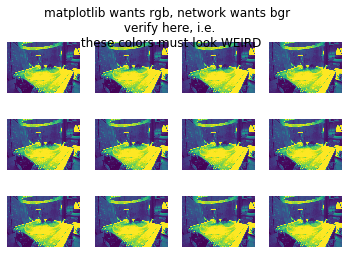

In [9]:
# geneate some frames, show as video to see that it's working!
for _ in range(1):    
#     im,target = random_from( MouseTrainLoader)
    index,im_batch = next(iter( FrameLoader))
    print(im_batch.shape)
    print(im_batch.dtype)
    print(index)
    print(torch.max(im_batch))
    plt.figure(figsize=(6,4))
    for i in range(12):
        plt.subplot(3,4,1+i)
#         plt.imshow(np.moveaxis(im_batch[i,...].numpy(),0,2))
        plt.imshow(im_batch[i,...].numpy()[0,...])
        plt.axis('off')
    plt.suptitle('matplotlib wants rgb, network wants bgr \n verify here, i.e. \n these colors must look WEIRD')
    plt.show()

<img src="figs/pre_color_01.png" width = 50%>

In [10]:
# loop over the dataset and generate the score maps!

# function to pass through the network
def im_batch_2_scores(im_batch,model):
    inputs = im_batch.float().div(255.).cuda()
    model.eval()
    with torch.no_grad():
        # compute model output
        output = model(inputs)
        # get the resulting scores out! Drop the affinity maps
        scores = output[-1][:,:4,:,:]
    return scores.cpu().numpy()


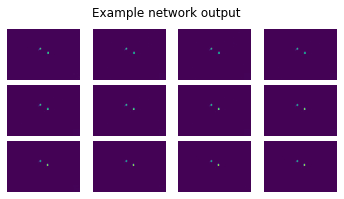

In [11]:
# plot some scores to see that it's fine
sco = im_batch_2_scores(im_batch,model)
plt.figure(figsize=(6,3))

for i in range(12):
    plt.subplot(3,4,1+i)
    plt.imshow(sco[i,1,:,:])
    plt.axis('off')
plt.suptitle('Example network output')
plt.subplots_adjust(hspace=.1,wspace=.1)    
plt.show()

<img src="figs/pre_color_02.png" width = 50%>

In [12]:
from skimage.feature import peak_local_max

def single_score_2_keypoints(sco):
    xy_list = [None]*4
    pxy_list = [None]*4
    score_idx_list = [None]*4
    for key in range(4):
        xy = peak_local_max(sco[key,:,:],threshold_abs = 0.1,num_peaks = 6)
        xy_list[key] = xy
        pxy_list[key] = sco[key,xy[:,0],xy[:,1]]
        # print(xy.shape)
        score_idx_list[key] = key * np.ones_like(xy)

    return np.concatenate(xy_list), np.concatenate(pxy_list), np.concatenate(score_idx_list)

def save_keypoints(dev,index,sco,hf_file):
    for i in range(len(index)):
        xy, pxy, score_idx = single_score_2_keypoints(sco[i,...])
        # stack everythong together in a list
        data_string = np.hstack( [xy.ravel(), np.round(pxy*100).astype('int') ,score_idx[:,0]])
        hf_file['dataset'][index[i]] = data_string

    

# Pass all images through the net and save the detected keypoints in hdf5 file

In [14]:
# from tqdm.auto import tqdm # to automatically use tqdm notebook
# from tqdm import tqdm_notebook as tqdm

for dev in range(4):
# for dev in [1,2,3]:
    # make the file, if it does not already exist
    hdf5_file_path = top_folder_0+'/keypoints_'+str(dev)+'.hdf5'
    if os.path.exists(hdf5_file_path) and False:
        print(hdf5_file_path+" was already done!")
        continue
    else:
        print("starting "+hdf5_file_path+"...")
        
    # make a frame loader
    FrameLoader = data.DataLoader( ReadDataset(dev,png_files,high_res=True) , batch_size=48, 
                                  shuffle=False, num_workers = 1)
    
    # open the file
    n_pictures = len(png_files[dev])
    with h5py.File(hdf5_file_path, mode='w') as hdf5_file:
        # make the variable length dataset
        dt = h5py.special_dtype(vlen=np.dtype('int'))
        hdf5_file.create_dataset('dataset', (n_pictures,), dtype=dt)
        # save the keypoint to an h5py file by looping over!
        for index,im_batch in tqdm_notebook(FrameLoader):
            sco = im_batch_2_scores(im_batch,model)
            save_keypoints(dev,index,sco,hdf5_file)    
    
    print(hdf5_file_path+" is done!")
    

starting /media/chrelli/Data0/recording_20200828-114251//keypoints_0.hdf5...



/media/chrelli/Data0/recording_20200828-114251//keypoints_0.hdf5 is done!
starting /media/chrelli/Data0/recording_20200828-114251//keypoints_1.hdf5...



/media/chrelli/Data0/recording_20200828-114251//keypoints_1.hdf5 is done!
starting /media/chrelli/Data0/recording_20200828-114251//keypoints_2.hdf5...



/media/chrelli/Data0/recording_20200828-114251//keypoints_2.hdf5 is done!
starting /media/chrelli/Data0/recording_20200828-114251//keypoints_3.hdf5...



/media/chrelli/Data0/recording_20200828-114251//keypoints_3.hdf5 is done!


In [18]:
if False:
    # Wuick check to see if the data is in the h5py file
    with h5py.File(top_folder_0+'/keypoints_'+str(dev)+'.hdf5', mode='r') as hdf5_file:
        print(hdf5_file.keys())
        print(len(hdf5_file['dataset']))
        print( hdf5_file['dataset'][500] )
